## Introduction to Neural Networks


## Requirements

In [ ]:
!pip install mnist

In [ ]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sys 

### Automatic differentiation

The autograd package allows automatic differentiation.

**Example :**

$$f(x) = 2\sqrt{x} + 1$$

$$f'(x) = \frac{1}{\sqrt{x}}$$

In [ ]:
# Imports

import autograd
import autograd.numpy as np

In [ ]:
# Example

def test_function(x):
    return 2.* np.sqrt(x) + 1.

def hardcoded_derivative(x):
    return 1 / np.sqrt(x)

autograd_derivative = autograd.grad(test_function)

In [ ]:
# Verify that the autograd derivative andhardcoded derivative are equal to the 14th decimals
assert round(autograd_derivative(2.), 14) == round(hardcoded_derivative(2.), 14)

print(autograd_derivative(2.)) # Round up
print(hardcoded_derivative(2.)) # Round down

0.7071067811865476
0.7071067811865475


### Display **functions**

In [ ]:
def displayFunc(f, xmin=-5., xmax=5., by=0.02):
    """
    Display the function f and its derivative f' between
    intervalle xmin and xmax with step by

    This function uses the Abstract Class Function which
    will be defined a bit further down.
    """
    t = np.arange(xmin, xmax, by)

    plt.subplot(1, 2, 1)
    plt.plot(t, f.eval(t))
    plt.title(type(f).__name__)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(t, f.eval_deriv(t))
    plt.grid(True)
    plt.title("Derivative of " + type(f).__name__)

    plt.show()

In [ ]:
def display1D(NN, xmin=-4., xmax=4., n=100):
    """
    Display the output of a MultiLayers Perceptron over 1D
    """
    x = np.linspace(xmin, xmax, n)
    y = NN.forward(x)
    plt.plot(x, y[0,:])


In [ ]:
def displayClassif(NN, xmin=-5., xmax=5., n=100, end=True):
    """
    Display the output of a MultiLayers Perceptron as Classication Areas
    The input of the NN must be 2D
    """
    discr = np.linspace(xmin, xmax, n)
    x=np.array([(i, j) for i in discr for j in discr]).T
    output = np.reshape(NN.forward(x), (len(discr), len(discr)))
    classif = (output>0.5).astype(float)

    fig, (ax1,ax2) = plt.subplots(figsize=(13, 4), ncols=2)
    pos = ax1.imshow(output.T,extent=[min(discr), max(discr), min(discr), max(discr)],origin='lower')
    fig.colorbar(pos, ax=ax1)
    ax1.set_title("Neural network output")

    pos = ax2.imshow(classif.T,extent=[min(discr), max(discr), min(discr), max(discr)],origin='lower')
    fig.colorbar(pos)
    ax2.set_title("Classification")
    if end:
        plt.show()
    

In [ ]:
def view_classify(img, ps):
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

### Activation functions

Our first step will be to code the NN activation
functions.


1.   Defining the abstract Activation class
2.   Defining some of the classical Activation functions




#### Abstract class


In [ ]:
from abc import ABC, abstractmethod

class Activation(ABC):
    def __init__(self):
        self.deriv = autograd.elementwise_grad(self.eval)
        pass

    @abstractmethod
    def eval(self, x):
        pass
    
    def eval_deriv(self, x):
        return self.deriv(x)
        

#### Identity function

$$f(x) = x$$

$$f'(x) = 1$$

1) ***Using the abstract class inheritence allows you to not specify the derivative.***

Since the subclass will use the parent's function, and since the parent's function uses the autograd, this option is perfect for lazy coders.

In [ ]:
class IdentityLazy(Activation):
    def eval(self,x):
        return x

In [ ]:
uLazy = IdentityLazy()
uLazy.eval_deriv(4.)

array(1.)

2) ***However, if the derivative is known, it is useless (and possibly time consuming) to make your activation inherit from Activation.***

In [ ]:
class Identity():
    def eval(self, x):
        return x
    
    def eval_deriv(self, x):
        return np.ones_like(x)

In [ ]:
u = Identity()
u.eval_deriv(4.)

array(1.)

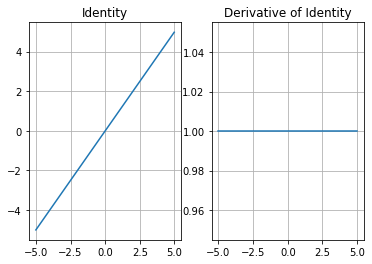

In [ ]:
displayFunc(u)

Proof that autograd is slower :

In [ ]:
%timeit uLazy.eval_deriv(4.)

The slowest run took 8.39 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 5: 22.2 µs per loop


In [ ]:
%timeit u.eval_deriv(4.)

The slowest run took 12.00 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 4.89 µs per loop


#### Sigmoid (a.k.a logistic function)

$$f(x) = \frac{1}{1+e^{-x}}$$

$$f'(x) = f(x)  (1-f(x))$$

In [ ]:
class Sigmoid():
    def eval(self, x):
        return 1. / (1. + np.exp(-x))

    def eval_deriv(self, x):
        p = self.eval(x)
        return p * (1-p)

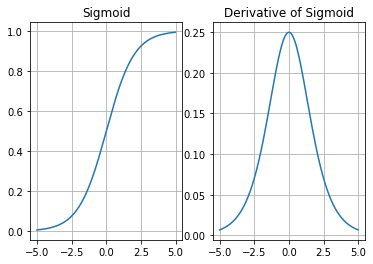

In [ ]:
displayFunc(Sigmoid())

#### SoftMax (for multi-label classification)

It is the inverse transformation of the centered log-ratio

$$f(x_1,\dots,x_K)=\frac{1}{\sum_{k=1}^K e^{x_k}}\left(\begin{array}{c} e^{x_1} \\ \vdots \\ e^{x_K}\end{array}\right)$$

If SoftMax is used for binary classification, it corresponds to the sigmoid function up to a reparametrization.

http://web.stanford.edu/~nanbhas//blog/sigmoid-softmax.html

#### Hyperbolic tangent

$$f(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$

$$f'(x) = 1 - f^2(x)$$

In [ ]:
class HyperbolicTangent():
    def eval(self,x):
        return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))

    def eval_deriv(self,x):
        return  1 - self.eval(x)**2    

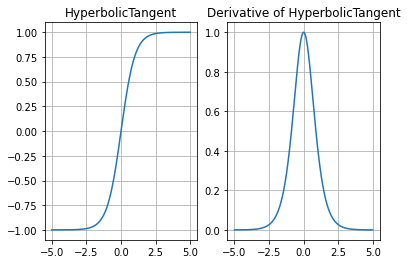

In [ ]:
displayFunc(HyperbolicTangent())

#### ReLU (Rectified Linear Unit)

$$f(x) = \max(0,x) = x \mathbb{1}_{]0,+\infty[}(x)$$

$$f'(x) = \mathbb{1}_{]0,+\infty[}(x)$$

In [ ]:
class ReLU():
    def eval(self, x):
        return x * self.eval_deriv(x)  # Do not make ReLu inherit from Activation
    
     def eval_deriv(self, x):
        return  (x >= 0).astype(float)     

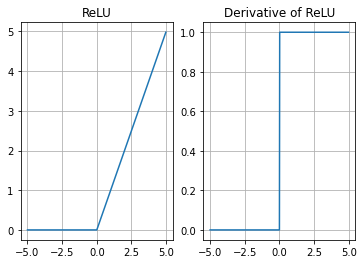

In [ ]:
displayFunc(ReLU())

#### Leaky ReLU

$$f(x) = \max(\varepsilon x,x)$$

$$f'(x) = \varepsilon\mathbb{1}_{]-\infty,0[}(x) + \mathbb{1}_{]0,+\infty[}(x)$$

In [ ]:
class LeakyReLU():
    def __init__(self, eps):
        self.eps = eps
            
    def eval(self, x):
        return x * self.evalderiv(x)   # Do not make LeakyReLu inherit from Activation

    def evalderiv(self, x):
        indic = (x >= 0).astype(float)     
        return  self.eps * (1. - indic) + indic

## I. First implementation of the MultiLayer Perceptron class

In the following code, you will build the class for a layer.

A layer is specified by the dimension of the input (Ninput), the dimension of the ouput (Noutput), and an activation function (an object with a method "eval").

The forward function computes the output of a given layer from the input vector. Note that the input vector does not include the constant 1 for the bias term.

In [ ]:
# Q1

class DenseLayer:

    def __init__(self, input_dim=1, output_dim=1, activation=Identity(), seed=None, L=1):
        """
        input_dim: int, input dimension
        output_dim: int, output dimension
        activation: an activation class with both eval and eval_deriv functions
        seed: int, random seed
        L: random intervalle
        """
        self.activation=activation
        self.weights=None
        self.init_random_weights(input_dim, output_dim, seed, L)

        # Cached objects
        self.tildeV=None
        self.S=None
        self.grad=None

    def init_random_weights(self, input_dim=None, output_dim=None, seed=None, L=1):
        """
        Create and Fill the weights matrix with random uniform number on [-L,L]
        If specified, the seed of the numpy random number generator will be set to seed

        input_dim and output_dim should be left to None only if weights are already initiated
        """

        if seed is not None:
            np.random.seed(seed)

        if input_dim is None:
            # No security check, but we'll assume the code will be used correctly
            self.weights = L * (np.random.rand( self.weights.shape[0], self.weights.shape[1])-0.5)
        else:      
            # TODO: Your code (fill the None)
            self.weights = L * (np.random.rand(output_dim, input_dim+1)-0.5) 
            # END

    def forward(self, V):
        """
        This function takes as entry a matrix (array) of size Ninput x N
        It returns the evaluation of the layer
        """
        V = np.atleast_2d(V) # See Glossary at the end of the notebook
        ones = np.ones(np.shape(V)[1])

        # TODO: Your code (fill the None)
        self.tildeV = np.row_stack((ones, V))
        self.S = self.weights @ self.tildeV
        result = self.activation.eval(self.S)
        # END

        return result

#### Test

After running the next chunk, "Success" has to be displayed. Otherwise, something is wrong

In [ ]:
# Code Verification
# (Do not edit)

A = DenseLayer(2, 1, sigmoid(), seed=24)

# 10 data (x will also be generated using the seed)
x = np.random.rand(2, 10)
expected_result = [0.72189383, 0.68976893, 0.67507701,0.73000272, 0.69081288,
                   0.68102093, 0.72774888, 0.72015744, 0.66509593, 0.71445135]
res = A.forward(x)
assert np.all(abs(res - expected_result)< 1e-5)

# 2 data (x will also be generated using the seed)
x = np.random.rand(1, 2)
A = DenseLayer(1, 1, sigmoid(), seed=24)
res = A.forward(x)
assert np.all(abs(res - [0.64467951, 0.65782785])< 1e-5)

# Sanity Check
print("Success")

Success


In [ ]:
ninput = 2
noutput = 1
ndata = 10
print("Weights :\n ", A.weights)

Weights :
  [[0.4600173  0.19951205]]


In [ ]:
class MultiLayerPerceptron:
    def __init__(self):
        self.layers = []

    def init_weights(self, seed=None, L=1):
        if seed is not None:
            np.random.seed(seed)

        for layer in self.layers:
            layer.init_random_weights(input_dim=None, output_dim=None, seed=seed, L=L)
            
    def add(self,layer):
        self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

### Linear Regression (1D)

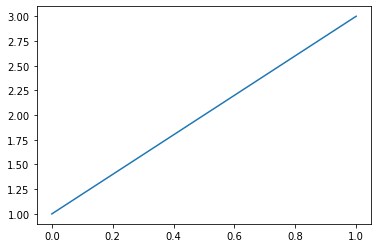

In [ ]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(1, 1, identity(), seed=9)
A1.weights[0][0] = 1.
A1.weights[0][1] = 2.
NN.add(A1)
display1D(NN, 0, 1)

### Non-linear Regression (1D)

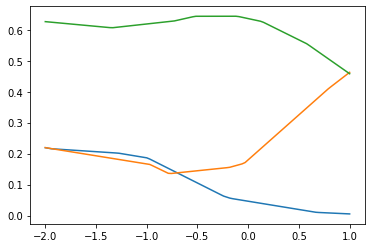

In [ ]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(1, 12, ReLU(), seed=3)
NN.add(A1)
A2 = DenseLayer(12, 1, identity())
NN.add(A2)
display1D(NN, -2, 1)
NN.init_weights(23)
display1D(NN, -2, 1)
NN.init_weights(24)
display1D(NN, -2, 1)

### Logistic Regression (2D)

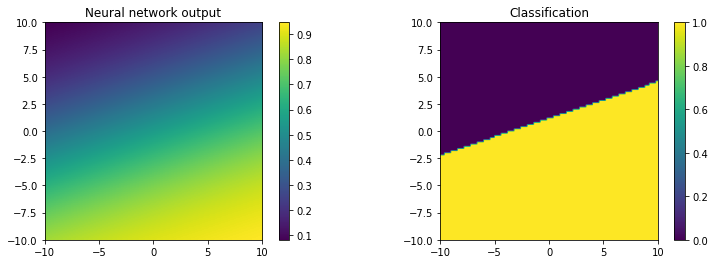

In [ ]:
NN = MultiLayerPerceptron()
A1 = DenseLayer(2, 1, sigmoid(), seed=98)
NN.add(A1)
displayClassif(NN, -10, 10)

### Binary classification (2D)

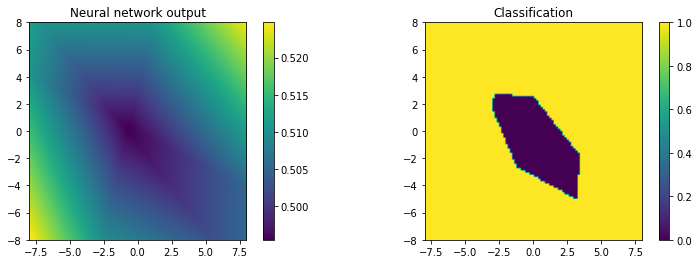

In [ ]:
Nhidden = 3
NN = MultiLayerPerceptron()

A1 = DenseLayer(2, Nhidden, ReLU(), seed=8, L=0.3)
A1.weights
NN.add(A1)
A2 = DenseLayer(Nhidden, 1, sigmoid())
NN.add(A2)
x=np.random.rand(ninput, ndata)
NN.forward(x)
displayClassif(NN, -8, 8)

## II. Evaluating a Neural Network

In [ ]:
class Cost(ABC):
    def __init__(self):
        self.deriv = autograd.elementwise_grad(self.funct)

    @abstractmethod
    def funct(self,predict,real):
        pass
    
    def eval(self,predict,real):
        return np.sum(self.funct(predict, real))
    
    def eval_deriv(self,predict,real):
        return self.deriv(predict,real)

### Cost functions

The cost function between the true value $y^{(t)}$ and the predicted value (or predicted probability for classification) $f_\omega(x)$ is given by $$L(y^{(t)},y^{(p)})=\frac{1}{n}\sum_{i=1}^n l(y_i^{(t)},y_i^{(p)})$$


#### Mean Squared Error

This function is used for regression where the output vector $y^{(p)}$ is generally the linear term of the last layer (identity activation):

$$l(y^{(p)},y^{(t)}) = \frac{1}{2}(y_i^{(p)}-y_i^{(t)})^2$$

#### Gradient


$$\frac{\partial L}{\partial y_i^{(p)}}= y_i^{(p)}-y_i^{(t)}$$ 


In [ ]:
class MeanSquare():
    def eval(self, predict, real):
        return 0.5 * np.sum((predict-real)**2)
    
    def eval_deriv(self, predict, real):
        return predict - real

#### Binary Cross-Entropy

This function is used for classification where the ouput vector $y^{(p)}$ is computed from the sigmoid function applied to the linear term of the last layer :

$$y^{(p)}_i = \frac{1}{1+e^{-s_i}}$$ 

$$L(y^{(p)},y^{(t)}) = -\sum_{i=1}^n \left(y_i^{(t)}\log(y_i^{(p)}) + (1-y_i^{(t)})\log(1-y_i^{(p)})\right)$$

#### Gradient

$$\frac{\partial L}{\partial y_i^{(p)}}= -\frac{y_i^{(t)}}{y_i^{(p)}}+\frac{1-y_i^{(t)}}{1-y_i^{(p)}}=\frac{y_i^{(p)}-y_i^{(t)}}{y_i^{(p)}  (1-y_i^{(p)})}$$ 

$$\frac{\partial L}{\partial s_i} = \frac{\partial L}{\partial y_i^{(p)}}\frac{\partial y_i^{(p)}}{\partial s_i} = 
y_i^{(p)}-y_i^{(t)}$$

In [ ]:
class BinaryCrossEntropy():
    def eval(self,predict,real):
        return - np.sum( real * np.log(predict) + (1-real)*np.log(1-predict) )
    
    def eval_deriv(self,predict,real):
        return (predict - real)/(predict*(1-predict))

### Remark:

For multi-label classification, the cost-function is generally the cross entropy:


$$L(y^{(p)},y^{(t)}) =-\sum_{i=1}^n \sum_{k=1}^K \left({y_k}_i^{(t)}\log({y_k}_i^{(p)})\right)$$

where $y_k^{(p)}$ is the predicted probability vector for the class $k$ and $y_k^{(t)}$ is the indicator vector of the class $k$.

Used with the softmax activation function for the output layer, similar simplifications occur.

## III. Learning Algorithm for a Neural Network

### Gradient of the cost function with respect to the weights

### 1) Back-propagation

In [ ]:
def BackPropGeneric(NN, x, real, cost):
    predict = NN.forward(x)
    l = NN.layers[-1]
    # dCost/df(y) = dCost/df(y) * df(y)/dy
    E = cost.eval_deriv(predict, real).T * l.activation.eval_deriv(l.linear).T

    # Last layer -> first layer
    for il in reversed(range(len(NN.layers))):
        # Since y = Wx + b
        # dy/dW = x => dCost/dW = dCost/dy * dy/dW = dCost/dy * x
        # dy/db = 1 => dCost/db = dCost/dy * dy/db = dCost/dy
        # Weights and Bias gradients for hidden layer := dCost/doutput.T @ input.T
        l.grad = E.T @ l.tildeV.T

        if il > 0:
            # dy/dx = W => dCost/dW = dCost/dy * dy/dx = dCost/dy * W
            E = E @ l.weights[:, 1:]
            l = NN.layers[il-1]
            E = E * l.activation.eval_deriv(l.S).T

            
def BackProp(NN, x, real, cost):
    predict = NN.forward(x)
    E = (predict - real).T
    for il in reversed(range(len(NN.layers))):
        l = NN.layers[il]
        l.grad = E.T @ l.tildeV.T
        if il > 0:
            lp = NN.layers[il-1]
            E = (E @ l.weights[:,1:]) * lp.activation.eval_deriv(lp.S).T

###  2) Finite differences

In [ ]:
def FinDiff(NN, x, real, cost=MeanSquare, delta=1e-6):

    res = [ np.zeros( np.shape(l.weights) )  for l in NN.layers  ]

    for s, l in enumerate(NN.layers):
        for j in range(l.weights.shape[0]):
            for k in range(l.weights.shape[1]):
    
                W = l.weights
                W[j,k] = W[j,k] + delta
                predict1 = NN.forward(x)
            
                W[j,k] = W[j,k] - 2 * delta
                predict2 = NN.forward(x)
                res[s][j,k] = (cost.eval(predict1 , real )- cost.eval(predict2 , real )) / (2*delta)
                W[j,k] = W[j,k] + delta
    return res

### Comparison of the two approaches